In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
from joblib import Parallel, delayed

2024-11-06 11:24:55.802385: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Introduction: Plot Structure Analysis for Movie Summaries

The goal of this notebook is to **process movie plot summaries to identify their underlying plot structures**. By categorizing each summary according to distinct narrative patterns, we aim to gain insights into common plot structures and explore potential correlations with financial success.

To achieve this, we experimented with **two different approaches**:

1. **Clustering**: We used unsupervised clustering (KMeans) on plot summaries to explore any emergent plot structure patterns.

2. **Large Language Model (LLM) Classification**: Using a predefined set of 15 plot structure categories, we use a LLM to classify each summary. This classification approach uses zero-shot prompting to assign each summary to a category.

# Importing the data

In [3]:
movies = pd.read_csv('../data/processed/merged_movies.csv')
summaries = pd.read_csv('../data/processed/summaries_preprocessed.csv')

In [ ]:
movies.head()

In [ ]:
summaries.head()

We keep only the summaries of the movies we have. We filter thanks to the `wikipedia_movie_id` feature

In [4]:
common_summaries = summaries[summaries['wikipedia_movie_id'].isin(movies['wikipedia_movie_id'])]

# 1. Clustering

## 1.1 Clustering only with the plot summaries

First, we transform the plot summaries into a numerical format for clustering by applying **TF-IDF (Term Frequency-Inverse Document Frequency) vectorization**. TF-IDF highlights important words in each summary by reducing the weight of common terms and increasing the importance of unique terms.

In [5]:
# Text Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(common_summaries['clean_plot_summary'])

# # Optional Step: Adding Genre Data (if available) to Enrich Clustering
# # Encode genre into numerical format and normalize it
# if 'movie_genres' in summaries.columns:
#     encoder = LabelEncoder()
#     summaries['genre_encoded'] = encoder.fit_transform(summaries['movie_genres'].fillna(''))
#     genre_embedding = np.expand_dims(summaries['genre_encoded'] / summaries['genre_encoded'].max(), axis=1)
#     combined_matrix = np.hstack((tfidf_matrix.toarray(), genre_embedding))
# else:
#     combined_matrix = tfidf_matrix.toarray()
combined_matrix = tfidf_matrix.toarray()

# # Step 3: Dimensionality Reduction (optional)
# pca = PCA(n_components=50)  # Reduce dimensions to speed up clustering
# reduced_matrix = pca.fit_transform(combined_matrix)

Now, we use **KMeans clustering** to group the plot summaries based on their TF-IDF representations. This step aims to identify distinct plot structure patterns by clustering similar summaries together.

**Parameters**:
- **n_clusters=10**: Specifies the number of clusters, initially set to 10. This value can be adjusted depending on the optimal number of clusters.
- **random_state=0**: Ensures reproducibility of clustering results.

The clustering labels are added to the dataset, allowing us to analyze plot structure patterns within each identified cluster.

To determine the optimal number of clusters, we plotted the **silhouette score** for cluster values ranging from 5 to 30. Typically, an ideal number of clusters shows a **peak in the silhouette score**.

However, in our plot, the silhouette score continually increases as the number of clusters increases.

Given these results, we will proceed with **15 clusters**. This number provides a balance between interpretability and granularity, allowing us to capture a range of plot structures without creating an excessive number of small, indistinct clusters.

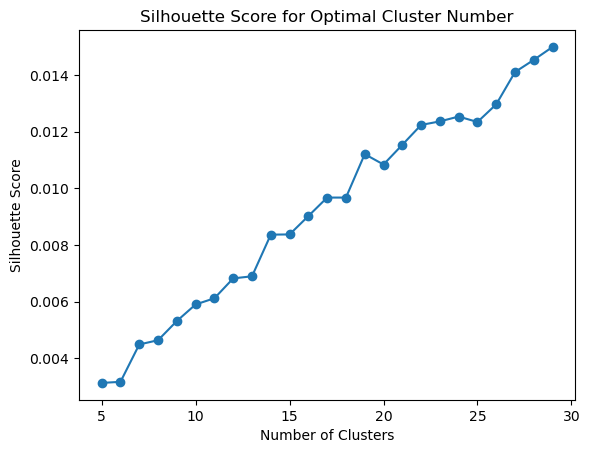

In [14]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for i in range(5, 30):
    kmeans = KMeans(n_clusters=i, random_state=0)
    labels = kmeans.fit_predict(combined_matrix)
    score = silhouette_score(combined_matrix, labels)
    silhouette_scores.append(score)

plt.plot(range(5, 30), silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal Cluster Number")
plt.show()

In [15]:
# Clustering with KMeans
n_clusters = 15 # Number of clusters to experiment with, can be adjusted
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
common_summaries['plot_structure_cluster'] = kmeans.fit_predict(combined_matrix)

/var/folders/34/0658nngn4kg11s2f10mpfs540000gn/T/ipykernel_34291/3160528659.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_summaries['plot_structure_cluster'] = kmeans.fit_predict(combined_matrix)


In [16]:
common_summaries['plot_structure_cluster'].value_counts()

plot_structure_cluster
2     2593
10    1224
7     1210
6      953
12     922
14     420
4      243
8      213
11     144
5      141
0      134
1       88
13      85
9       65
3       51
Name: count, dtype: int64

The **distribution of plot summaries across clusters** shows that the clustering algorithm has created some clusters with a significantly higher number of summaries than others. The top three clusters (2, 10, and 7) collectively hold a large portion of the summaries, indicating that certain plot structures may be more common. We have to dive more in the clusters.

**Top Terms per Cluster**

To gain a better understanding of each cluster's underlying plot structure, we examine the **top terms** associated with each cluster. By averaging the **TF-IDF values** of terms within each cluster, we identify the 10 most representative words for each group. This allows us to interpret the clusters.

In [18]:
# Cluster Interpretation
# Get the top terms per cluster by averaging the TF-IDF values of the terms in each cluster
terms = tfidf_vectorizer.get_feature_names_out()
cluster_centers = kmeans.cluster_centers_
top_terms_per_cluster = []

for i in range(n_clusters):
    top_terms_idx = cluster_centers[i].argsort()[-10:]  # Top 10 terms per cluster
    top_terms_per_cluster.append([terms[idx] for idx in top_terms_idx])

# Display top terms per cluster for interpretation
for i, terms in enumerate(top_terms_per_cluster):
    print(f"Cluster {i+1} top terms: {', '.join(terms)}")



Cluster 1 top terms: finds, home, mary, tells, charley, jane, peters, jerry, ray, peter
Cluster 2 top terms: kevin, plane, money, david, kate, base, agent, maxs, bond, max
Cluster 3 top terms: wife, relationship, man, woman, young, story, new, life, love, film
Cluster 4 top terms: father, home, annie, charlie, alice, children, son, money, car, chris
Cluster 5 top terms: duke, palace, kingdom, kings, princess, castle, prince, queen, mary, king
Cluster 6 top terms: wife, love, greg, father, family, new, life, tells, jacks, jack
Cluster 7 top terms: killed, earth, captain, mission, men, soldiers, crew, army, ship, war
Cluster 8 top terms: man, killer, case, money, car, gang, murder, charlie, harry, police
Cluster 9 top terms: home, new, family, car, father, sams, michaels, jake, sam, michael
Cluster 10 top terms: goes, sarah, henry, family, new, jerry, film, father, house, tom
Cluster 11 top terms: tells, home, johnny, town, sarah, mr, alex, george, ben, house
Cluster 12 top terms: man, c

### Interpretation of Cluster Themes

Here’s an interpretation of each cluster based on the top terms:

- **Cluster 1**: character-driven plots centered around relationships.
- **Cluster 2**: action or espionage themes, maybe involving military or spy-related narratives.
- **Cluster 3**: romantic or life stories focused on relationships.
- **Cluster 4**: Plots around family reliationships.
- **Cluster 5**: royalty and historical or fantasy settings with themes of nobility.
- **Cluster 6**: domestic life or family-centered stories.
- **Cluster 7**: military or wartime narratives with themes of heroism or survival.
- **Cluster 8**: crime or thriller themes, often involving investigation or criminal pursuits.
- **Cluster 9**: domestic or personal stories with a focus on family.
- **Cluster 10**: character-centered family narratives with elements of drama or personal growth.
- **Cluster 11**: small-town settings or domestic life with local interpersonal relationships.
- **Cluster 12**: crime or drama narratives involving family or authority figures.
- **Cluster 13**: family dynamics or coming-of-age themes.
- **Cluster 14**: domestic drama with possible criminal elements.
- **Cluster 15**: school or educational settings with themes of growth, learning, or competition.

Each cluster reveals distinct themes and settings. While this analysis helps to identify common elements within each group, **we are not fully satisfied with this approach** as it appears to capture **genre and themes more than specific plot structures**. 

Since our goal is to identify different types of plot structures, clustering based solely on keywords may lack the depth needed to capture narrative progression and plot dynamics. Consequently, we explore alternative methods, such as leveraging large language models or deeper natural language processing techniques, to classify plot structures more accurately.

In [11]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline


# Define model cache directory
cache_dir = "../LLM_cache"

# Create the cache directory if it does not exist
os.makedirs(cache_dir, exist_ok=True)

model_name = "google/flan-t5-large"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, cache_dir=cache_dir)
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)

# Initialize the classifier pipeline
classifier = pipeline("text2text-generation", model=model, tokenizer=tokenizer, framework="pt")


# Define the complete list of categories
predefined_categories = [
    "Hero’s Journey and Transformation",
    "Quest for Vengeance or Justice",
    "Coming of Age and Self-Discovery",
    "Survival or Escape",
    "Rise and Fall of a Protagonist",
    "Love and Relationship Dynamics",
    "Comedy of Errors or Misadventure",
    "Crime and Underworld Exploration",
    "Power Struggle and Betrayal",
    "Mystery and Conspiracy Unveiling",
    "Tragedy and Inevitability",
    "Conflict with Supernatural or Unknown Forces",
    "Comedy in Domestic Life",
    "Social Rebellion or Fight Against Oppression",
    "Fantasy or Science Fiction Quest"
]

# Long prompt
# prompt = """
# Classify the following plot summary into one of these categories:
# 1. Hero’s Journey and Transformation: The protagonist undergoes personal growth, often starting as an ordinary individual who faces challenges, gains allies, overcomes obstacles, and returns transformed.
# 2. Quest for Vengeance or Justice: A revenge-driven plot where the protagonist seeks retribution or justice for a past wrong or injustice.
# 3. Coming of Age and Self-Discovery: The protagonist matures or gains self-awareness, often overcoming personal or societal obstacles.
# 4. Survival or Escape: The story revolves around characters trying to survive dangerous situations or escape captivity.
# 5. Rise and Fall of a Protagonist: The protagonist experiences a rise to power or success, followed by a tragic or inevitable downfall.
# 6. Love and Relationship Dynamics: Focuses on romantic or family relationships, often dealing with misunderstandings, unions, reconciliations, or unfulfilled love.
# 7. Comedy of Errors or Misadventure: Characters experience humorous, unintended consequences or misadventures while pursuing a goal.
# 8. Crime and Underworld Exploration: The story explores criminal activities or the underworld, often involving heists, gang conflicts, or undercover missions.
# 9. Power Struggle and Betrayal: Focuses on conflicts for power or leadership, with betrayal as a central theme, often involving shifting alliances.
# 10. Mystery and Conspiracy Unveiling: The protagonist uncovers a hidden conspiracy, solves puzzles, or discovers hidden truths.
# 11. Tragedy and Inevitability: A character-driven plot where the protagonist faces an inevitable negative outcome, often due to a flaw or external betrayal.
# 12. Conflict with Supernatural or Unknown Forces: The protagonist encounters supernatural entities, unknown forces, or sci-fi elements that pose existential challenges.
# 13. Comedy in Domestic Life: Focuses on the humor and challenges of family life, with everyday misunderstandings and domestic issues driving the plot.
# 14. Social Rebellion or Fight Against Oppression: The protagonist challenges societal norms or oppressive systems, leading to personal or collective change.
# 15. Fantasy or Science Fiction Quest: Centers on a journey or quest in a fantastical or sci-fi setting, involving world-building, encounters with non-human entities, and mythical or technological challenges.

# Choose only one category from the list.

# Summary: "{}"
# Classification (choose one):
# """

# Short prompt
prompt = """
Classify the following plot summary into one of these categories:
1. Hero’s Journey and Transformation: Personal growth and overcoming challenges.
2. Quest for Vengeance or Justice: Seeking retribution or justice.
3. Coming of Age and Self-Discovery: Maturation or self-awareness.
4. Survival or Escape: Danger and resilience.
5. Rise and Fall of a Protagonist: Success followed by a tragic downfall.
6. Love and Relationship Dynamics: Focus on romantic or family relationships.
7. Comedy of Errors or Misadventure: Humorous, unintended consequences.
8. Crime and Underworld Exploration: Criminal activities, heists, or gang conflicts.
9. Power Struggle and Betrayal: Conflicts for power, often with betrayal.
10. Mystery and Conspiracy Unveiling: Discovering hidden truths or solving puzzles.
11. Tragedy and Inevitability: Inevitable negative outcomes due to fate or flaw.
12. Conflict with Supernatural or Unknown Forces: Supernatural or sci-fi challenges.
13. Comedy in Domestic Life: Family life and misunderstandings.
14. Social Rebellion or Fight Against Oppression: Challenging societal norms.
15. Fantasy or Science Fiction Quest: Journey in a fantastical or sci-fi setting.

Choose only one category.

Summary: "{}"
Classification (choose one):
"""

# Function to classify each plot summary
def classify_summary(summary):
    input_prompt = prompt.format(summary)
    response = classifier(input_prompt, max_length=15)  # Limit response length to avoid extra text
    classification = response[0]['generated_text'].strip()
    return classification
    # # Validate that response matches one of the categories
    # if classification in predefined_categories:
    #     return classification
    # else:
    #     return "Uncategorized"  # Handle cases where the response doesn't match any category

# # Apply classification to dataset
# summaries['plot_structure'] = summaries['plot_summary'].apply(classify_summary)

# # Save results to CSV if needed
# summaries.to_csv('/mnt/data/classified_summaries_with_plot_structures.csv', index=False)


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
test_sample = common_summaries.sample(10, random_state=1)
test_sample['plot_structure'] = test_sample['clean_plot_summary'].apply(classify_summary)

Token indices sequence length is longer than the specified maximum sequence length for this model (1082 > 512). Running this sequence through the model will result in indexing errors


: 

In [9]:
# see what is the longest summary in common_summaries
max_len = max(common_summaries['clean_plot_summary'].apply(lambda x: len(x.split())))
print(max_len)

# print stats about len of summaries
print(common_summaries['clean_plot_summary'].apply(lambda x: len(x.split())).describe())

3515
count    8486.000000
mean      495.188310
std       351.862229
min        13.000000
25%       185.000000
50%       476.000000
75%       713.000000
max      3515.000000
Name: clean_plot_summary, dtype: float64


In [ ]:
test_sample

In [ ]:
batch_size = 500
output_dir = '../data/classified_summaries_batches'
os.makedirs(output_dir, exist_ok=True)

sample_summaries = common_summaries.sample(1500)

# Process each batch and save to checkpoint files
for i in range(0, len(summaries), batch_size):
    batch = sample_ummaries.iloc[i:i + batch_size].copy()  # Work with a copy to avoid modifying the original DataFrame
    
    # Parallel processing of classification within the batch
    batch['plot_structure'] = Parallel(n_jobs=4)(delayed(classify_summary)(summary) for summary in batch['clean_plot_summary'])
    
    # Save the processed batch to a CSV file as a checkpoint
    batch.to_csv(f"{output_dir}/classified_summaries_batch_{i}.csv", index=False)



In [ ]:
# Optional: Combine all batch files into a single file after processing
all_batches = [pd.read_csv(f"{output_dir}/classified_summaries_batch_{i}.csv") for i in range(0, len(summaries), batch_size)]
classified_summaries = pd.concat(all_batches, ignore_index=True)
classified_summaries.to_csv('../data/processed/classified_summaries_with_plot_structures.csv', index=False)